# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Загружаем библиотеки

In [1]:
#!pip install pandas-profiling[notebook]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

/tmp/ipykernel_178/1947923526.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport



<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [3]:
# Определим random_state
ran_st= 12345

## Загрузка и подготовка данных

Загрузим данные

In [4]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Данные геологоразведки 1 региона

In [5]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_0.duplicated().sum()

0

In [8]:
data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [10]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Данные геологоразведки 2 региона

In [11]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
data_1.duplicated().sum()

0

In [14]:
data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [15]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [16]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Данные геологоразведки 3 региона

In [17]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [18]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [19]:
data_2.duplicated().sum()

0

In [20]:
data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [21]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [22]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


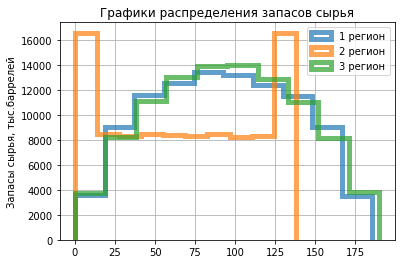

In [23]:
plt.title('Графики распределения запасов сырья')
plt.figsize=(15,10)
ax=data_0['product'].plot(kind='hist',grid=True, legend=True, alpha=0.7, histtype='step', linewidth=2, label='1 регион')
data_1['product'].plot(kind='hist',grid=True, legend=True, alpha=0.7,histtype='step', linewidth=2, label='2 регион', ax=ax)
data_2['product'].plot(kind='hist',grid=True, legend=True, alpha=0.7,histtype='step', linewidth=2, label='3 регион', ax=ax)
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

Данные пригодны для анализа, пропусков  и дубликатов нет.

Были внесены следующие изменения:

Анализ корреляций показывает незначительную зависимость между перменными и результирующим фактором, кроме переменной f2. Данные корреляций значений второго регоина показывают очень сильную зависимость целевого показателя от f0, такая зависмость можеть дать нам высокие баллы предсказаний для нашей модели.

In [24]:
profile = ProfileReport(data_0, title="Pandas Profiling Report")

# запускаем показ профиля
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение и проверка модели

Признак id является неинформативным, поэтому  удалим его из всех датасетов. 
Было: Для возможности обучения моделей, перекодируем данные при помощи метода OrdinalEncoder

In [25]:
# encoder_0 = OrdinalEncoder()
# data_ordinal_0 = pd.DataFrame(encoder_0.fit_transform(data_0), columns=data_0.columns)
# data_0['id'] = (data_ordinal_0['id']).astype('int')
# data_0.describe()

In [26]:
data_0=data_0.drop(['id'], axis=1)
data_1=data_1.drop(['id'], axis=1)
data_2=data_2.drop(['id'], axis=1)

Разобьём данные на признаки

In [27]:
target_0=data_0['product']
features_0=data_0.drop(['product'], axis=1)

target_1=data_1['product']
features_1=data_1.drop(['product'], axis=1)

target_2=data_2['product']
features_2=data_2.drop(['product'], axis=1)

Разобьём данные на обучающую и валидационную выборки в соотношении 3:1

In [28]:
# for i in range(3):
#     features_train_{i}, features_valid_{i}, target_train_{i}, target_valid_{i} = train_test_split(features_{i}, target_{i}, test_size=0.25, random_state=ran_st)

# print(f'Размер тренировочной выборки 0- {target_train_i.shape[0]/target_0.shape[0]:.0%}')
# print(f'Размер валидационной выборки 0- {target_valid_i.shape[0]/target_0.shape[0]:.0%}')

In [29]:


features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=ran_st)

print(f'Размер тренировочной выборки 0- {target_train_0.shape[0]/target_0.shape[0]:.0%}')
print(f'Размер валидационной выборки 0- {target_valid_0.shape[0]/target_0.shape[0]:.0%}')

Размер тренировочной выборки 0- 75%
Размер валидационной выборки 0- 25%


In [30]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=ran_st)

print(f'Размер тренировочной выборки 1- {target_train_1.shape[0]/target_1.shape[0]:.0%}')
print(f'Размер валидационной выборки 1- {target_valid_1.shape[0]/target_1.shape[0]:.0%}')

Размер тренировочной выборки 1- 75%
Размер валидационной выборки 1- 25%


In [31]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=ran_st)

print(f'Размер тренировочной выборки 2- {target_train_2.shape[0]/target_2.shape[0]:.0%}')
print(f'Размер валидационной выборки 2- {target_valid_2.shape[0]/target_2.shape[0]:.0%}')


Размер тренировочной выборки 2- 75%
Размер валидационной выборки 2- 25%


In [34]:
#Добавлено студентом
def model_LR(features_train,target_train, features_valid, target_valid, region):
    model = LinearRegression().fit(features_train, target_train)
    predict = model.predict(features_valid_0)
    rmse = mean_squared_error(target_valid_0, predict)**0.5
    r2_sc = r2_score(target_valid, predict)

    print(f'Регион {region} Среднеквадратичная ошибка RMSE: {rmse: .2f}')
    print(f'Регион {region} Коэффициент детерминации: {r2_sc: .2f}')
    return predict, rmse, r2_sc

In [35]:
# Для региона 1
predict_0, rmse_0, r2_score_0 = model_LR(features_train_0, target_train_0, features_valid_0, target_valid_0, 1)

Регион 1 Среднеквадратичная ошибка RMSE:  37.58
Регион 1 Коэффициент детерминации:  0.28


In [36]:
# Для региона 2
predict_1, rmse_1, r2_score_1 = model_LR(features_train_1, target_train_1, features_valid_1, target_valid_1, 2)

Регион 2 Среднеквадратичная ошибка RMSE:  79.96
Регион 2 Коэффициент детерминации: -3.63


In [37]:
# Для региона 3
predict_2, rmse_2, r2_score_2 = model_LR(features_train_2, target_train_2, features_valid_2, target_valid_2, 3)

Регион 3 Среднеквадратичная ошибка RMSE:  38.94
Регион 3 Коэффициент детерминации: -0.16


In [38]:
# model_2=LinearRegression().fit(features_train_2,target_train_2)
# predict_2=model_2.predict(features_valid_2)
# rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
# print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
# print('Коэффициент детерминации: %.2f' % r2_score(target_valid_2, predict_2))


In [39]:
tabl = pd.DataFrame(index=['Средний Запас сырья','RMSE модели'], columns=['1 регион','2 регион','3 регион'])
tabl['1 регион'] = predict_0.mean(), rmse_0
tabl['2 регион'] = predict_1.mean(), rmse_1
tabl['3 регион'] = predict_2.mean(), rmse_2

print(tabl)

                      1 регион   2 регион   3 регион
Средний Запас сырья  92.592568  68.760837  95.012249
RMSE модели          37.579422  79.960208  38.940652


Вывод

Проведено обучение моделей и посчитана метрика RMSE, которая определяет величину среднеквадратичной ошибки. Исходя из полученных данный можно заметить, что величина RMSE во втором регионе сильно отличается от двух других.

##  Подготовка к расчёту прибыли


 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [41]:
TOTAL_COST = 10_000_000 #Бюджет на разработку скважин в регионе, тыс.руб
INCOME_PER_BARREL = 450 #Доход с каждой единицы продукта, тыс.руб
TARGET_PROBABILITY_LOSSES = 0.025 # вероятность убытков

In [42]:
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

In [43]:
print(f'Cредний запас сырья в 1 регионе: {product_mean_0: .2f}  млн.баррелей')
print(f'Cредний запас сырья в 2 регионе: {product_mean_1: .2f}  млн.баррелей')
print(f'Cредний запас сырья в 3 регионе: {product_mean_2: .2f}  млн.баррелей')

Cредний запас сырья в 1 регионе:  92.50  млн.баррелей
Cредний запас сырья в 2 регионе:  68.83  млн.баррелей
Cредний запас сырья в 3 регионе:  95.00  млн.баррелей


In [44]:
COST_1WELL = (TOTAL_COST/200)# тыс.руб
print('Стоимость разработки одной скважины: ', COST_1WELL,'тыс.руб')

Стоимость разработки одной скважины:  50000.0 тыс.руб


In [45]:
OUTPUT_POINT = COST_1WELL/INCOME_PER_BARREL
print(f'Объём добычи каждой скважины для безубыточноcти {OUTPUT_POINT: .2f} тыс.баррелей')

Объём добычи каждой скважины для безубыточноcти  111.11 тыс.баррелей


Поcчитаем потенциальную выручку

In [46]:
data_0['revenue']=(data_0['product']*(INCOME_PER_BARREL)).round(2) # тыс.руб
#data_0.head()

In [47]:
data_1['revenue']=(data_1['product']*(INCOME_PER_BARREL)).round(2) # тыс.руб
#data_1.head()

In [48]:
data_2['revenue']=(data_2['product']*(INCOME_PER_BARREL)).round(2) # тыс.руб
#data_2.head()

Посчитаем roi в регионе

In [49]:
data_0['roi']=((data_0['revenue']/COST_1WELL)-1).round(3)
data_0.head()

,f0,f1,f2,product,revenue,roi
0,0.705745,-0.497823,1.221170,105.280062,47376.03,-0.052
1,1.334711,-0.340164,4.365080,73.037750,32866.99,-0.343
2,1.022732,0.151990,1.419926,85.265647,38369.54,-0.233
3,-0.032172,0.139033,2.978566,168.620776,75879.35,0.518
4,1.988431,0.155413,4.751769,154.036647,69316.49,0.386


In [50]:
data_1['roi']=((data_1['revenue']/COST_1WELL)-1).round(3)
data_1.head()

,f0,f1,f2,product,revenue,roi
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-0.971
1,14.272088,-3.475083,0.999183,26.953261,12128.97,-0.757
2,6.263187,-5.948386,5.001160,134.766305,60644.84,0.213
3,-13.081196,-11.506057,4.999415,137.945408,62075.43,0.242
4,12.702195,-8.147433,5.004363,134.766305,60644.84,0.213


In [51]:
data_2['roi']=((data_2['revenue']/COST_1WELL)-1).round(3)
data_2.head()

,f0,f1,f2,product,revenue,roi
0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-0.750
1,0.262778,0.269839,-2.530187,56.069697,25231.36,-0.495
2,0.194587,0.289035,-5.586433,62.871910,28292.36,-0.434
3,2.236060,-0.553760,0.930038,114.572842,51557.78,0.031
4,-0.515993,1.716266,5.899011,149.600746,67320.34,0.346


Выполним привязку индексов скважин к предсказаниям модели и отсорируем список по убыванию

In [52]:
probs_sorted_0 = pd.Series(predict_0, index=target_valid_0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:200]
selected_max_0

93073    180.180713
46784    176.252213
78948    175.850623
43388    175.658429
6496     173.299686
            ...    
30488    148.507064
98799    148.481767
53840    148.476498
4638     148.436761
75908    148.365941
Length: 200, dtype: float64

In [53]:
def profit_r(predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_well = probs_sorted[:count].sum()
    profit_pred=(selected_well*INCOME_PER_BARREL)-TOTAL_COST
    
    print(f'Суммарный запас сырья в 200 лучших скважинах составит: {selected_well: .2f} тыс.баррелей')
    print(f'Прибыль для полученного объёма сырья составит {profit_pred/1000: .2f} млн.рублей')
    return selected_well, profit_pred

In [54]:
#Для 1 региона
selected_well0, profit_pred0 = profit_r(predict_0,target_valid_0,200)

Суммарный запас сырья в 200 лучших скважинах составит:  31102.33 тыс.баррелей
Прибыль для полученного объёма сырья составит  3996.05 млн.рублей


In [55]:
#Для 2 региона
selected_well1, profit_pred1 = profit_r(predict_1,target_valid_1,200)

Суммарный запас сырья в 200 лучших скважинах составит:  60969.49 тыс.баррелей
Прибыль для полученного объёма сырья составит  17436.27 млн.рублей


In [56]:
#Для 3 региона
selected_well2, profit_pred2 = profit_r(predict_2,target_valid_2,200)

Суммарный запас сырья в 200 лучших скважинах составит:  29004.64 тыс.баррелей
Прибыль для полученного объёма сырья составит  3052.09 млн.рублей


## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [57]:
def profit_n(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * INCOME_PER_BARREL
    return revenue - TOTAL_COST
    print (revenue - TOTAL_COST)

In [60]:
def bootstrap_1000(target,predict):
    state = np.random.RandomState(12345)
    values = []
    risk=0
    predict_i = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        predict_subsample = predict_i[target_subsample.index]
        #print(probs_subsample)
        values.append(profit_n(predict_subsample,target_subsample))  
#     for i in values:
#         if i < 0:
#             risk +=1
    
     
    values = pd.Series(values)
    risk = (values < 0).mean() * 100     
    revenue_mean = values.mean()
    conf_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
   
    
    print(f"Средняя прибыль: {(revenue_mean/1000):.2f} млн руб.")
    print(f'С вероятностью 95% прибыль в данном регионе будет составлять от: {low_95/1000:.2f} млн.руб до: {high_95/1000:.2f} млн.руб')
    print(f"95%-ый доверительный интервал: от {conf_interval[0]/1000:.2f} млн.руб до {conf_interval[1]/1000:.2f} млн.руб")
    print (f'Процент вероятности убытка в данном регионе составит {risk/1000:.1%}')
    print(values.describe())
    
    return revenue_mean, risk, conf_interval    

  0%|          | 0/1000 [00:00<?, ?it/s]

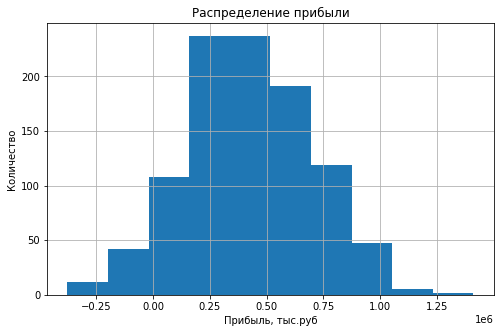

Средняя прибыль: 425.94 млн руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 0.6%
count    1.000000e+03
mean     4.259385e+05
std      2.772767e+05
min     -3.768427e+05
25%      2.344665e+05
50%      4.206723e+05
75%      6.192790e+05
max      1.409842e+06
dtype: float64


In [61]:
mean_revenue0, risk0, conf_interval0 = bootstrap_1000(target_valid_0,predict_0)


  0%|          | 0/1000 [00:00<?, ?it/s]

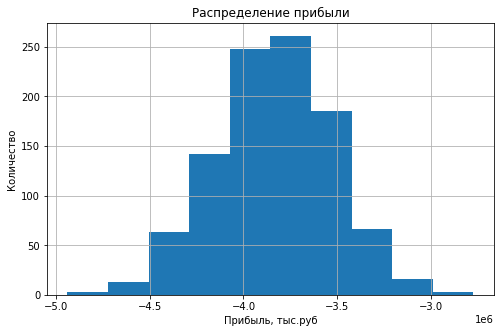

Средняя прибыль: -3836.84 млн руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: -4441.86 млн.руб до: -3257.40 млн.руб
95%-ый доверительный интервал: от -3856.28 млн.руб до -3817.41 млн.руб
Процент вероятности убытка в данном регионе составит 10.0%
count    1.000000e+03
mean    -3.836845e+06
std      3.131329e+05
min     -4.937556e+06
25%     -4.041458e+06
50%     -3.832762e+06
75%     -3.617675e+06
max     -2.775800e+06
dtype: float64


In [62]:
mean_revenue1, risk1, conf_interval1 = bootstrap_1000(target_valid_1,predict_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

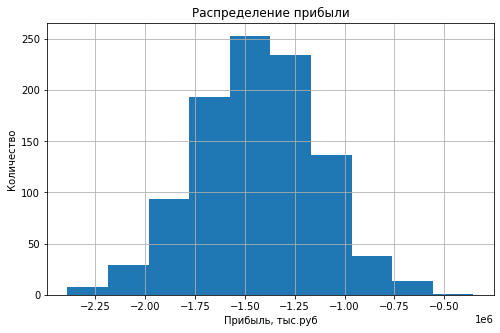

Средняя прибыль: -1437.62 млн руб.
С вероятностью 95% прибыль в данном регионе будет составлять от: -2025.31 млн.руб до: -874.20 млн.руб
95%-ый доверительный интервал: от -1456.63 млн.руб до -1418.62 млн.руб
Процент вероятности убытка в данном регионе составит 10.0%
count    1.000000e+03
mean    -1.437624e+06
std      3.062375e+05
min     -2.389457e+06
25%     -1.647934e+06
50%     -1.426103e+06
75%     -1.232945e+06
max     -3.548427e+05
dtype: float64


In [63]:
mean_revenue2, risk2, conf_interval2 = bootstrap_1000(target_valid_2,predict_2)

In [64]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = mean_revenue0/1000, selected_well0, risk0/1000
comparison_tabl['2 регион'] = mean_revenue1/1000, selected_well1, risk1/1000
comparison_tabl['3 регион'] = mean_revenue2/1000, selected_well2, risk2/1000
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн.руб",425.938527,-3836.844567,-1437.623620
"Суммарный запас сырья, тыс.баррелей",31102.330839,60969.485648,29004.642469
"Вероятность убытка, %",0.006000,0.100000,0.100000


**ОБЩИЙ ВЫВОД**

1. Был проведен анализ данных, проверили датасеты на наличие пропусков, дупликатов.
2. Построили линейную модель, для предсказания объемов нефти в скважинах.
3. Затем мы выполнили процедуру бутстрэпа и нашли 95% доверительный интервал для среднего объема нефти в скважинах. 
4. Выбрали наиболее перспективный регион для разработки. Им оказался "Регион№ 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован